In [14]:
# Instalación de librerías necesarias (ejecutar solo si hace falta)
!pip install scikit-learn pandas matplotlib seaborn openpyxl

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("✓ Librerías importadas correctamente")

✓ Librerías importadas correctamente


In [16]:
# Cargar datos desde SQLite
db_path = '../data/airbnb.db'
conn = sqlite3.connect(db_path)
df = pd.read_sql_query("SELECT * FROM listings", conn)
conn.close()

print(f"Dataset cargado: {df.shape[0]} registros, {df.shape[1]} columnas")
df[['id','price','accommodates','bedrooms','bathrooms','availability_365','number_of_reviews']].head()

Dataset cargado: 26401 registros, 77 columnas


,id,price,accommodates,bedrooms,bathrooms,availability_365,number_of_reviews
0,35797,3799.0,2,1.0,1.0,364,0
1,44616,18000.0,14,5.0,5.5,360,65
2,56074,585.0,2,1.0,1.0,338,84
3,67703,1696.0,4,2.0,1.0,267,50
4,70644,1004.0,2,1.0,1.0,211,132


In [17]:
# Selección de variables numéricas para clustering
features = [
    'price',
    'accommodates',
    'bedrooms',
    'bathrooms',
    'availability_365',
    'minimum_nights',
    'number_of_reviews',
    'latitude',
    'longitude'
]

df_cluster = df[features].copy()
print("Shape inicial:", df_cluster.shape)

# Ver nulos
print("\nNulos por columna:")
print(df_cluster.isnull().sum())

Shape inicial: (26401, 9)

Nulos por columna:
price                3274
accommodates            0
bedrooms              924
bathrooms            3281
availability_365        0
minimum_nights          0
number_of_reviews       0
latitude                0
longitude               0
dtype: int64


In [18]:
# Eliminar filas con nulos en variables clave
df_cluster = df_cluster.dropna()
print("Después de dropna:", df_cluster.shape)

# Filtrar outliers extremos de precio para que no dominen el clustering
p99 = df_cluster['price'].quantile(0.99)
df_cluster = df_cluster[(df_cluster['price'] >= 100) & (df_cluster['price'] <= p99)]
print("Después de filtrar outliers de precio:", df_cluster.shape)

df_cluster.describe()

Después de dropna: (23039, 9)
Después de filtrar outliers de precio: (22802, 9)


,price,accommodates,bedrooms,bathrooms,availability_365,minimum_nights,number_of_reviews,latitude,longitude
count,22802.000000,22802.000000,22802.000000,22802.000000,22802.000000,22802.000000,22802.000000,22802.000000,22802.000000
mean,1360.972809,3.304754,1.489694,1.418823,256.096834,3.843259,57.100298,19.406436,-99.165250
std,1198.169672,2.196034,1.060059,0.932582,106.654962,18.141617,86.033448,0.041608,0.033371
min,137.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,19.177848,-99.339630
25%,630.000000,2.000000,1.000000,1.000000,178.000000,1.000000,5.000000,19.394725,-99.178340
50%,1031.000000,2.000000,1.000000,1.000000,290.000000,2.000000,25.000000,19.415520,-99.167130
75%,1620.000000,4.000000,2.000000,2.000000,351.000000,2.000000,74.000000,19.432377,-99.153792
max,10000.000000,16.000000,50.000000,49.000000,365.000000,729.000000,1342.000000,19.549060,-98.966450


In [19]:
# Escalado de variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)

print("Shape de matriz escalada:", X_scaled.shape)

Shape de matriz escalada: (22802, 9)


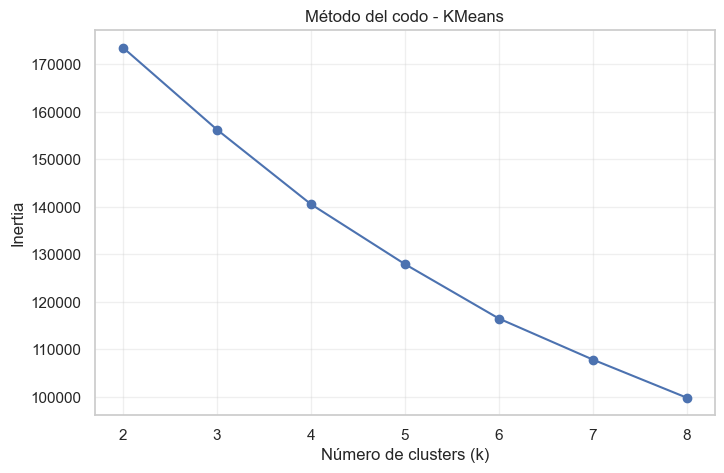

In [20]:
inertias = []
K = range(2, 9)

for k in K:
    kmeans_tmp = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_tmp.fit(X_scaled)
    inertias.append(kmeans_tmp.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K, inertias, marker='o')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inertia')
plt.title('Método del codo - KMeans')
plt.xticks(K)
plt.grid(True, alpha=0.3)
plt.show()

k=2, Silhouette=0.2988
k=3, Silhouette=0.2943
k=4, Silhouette=0.1710
k=5, Silhouette=0.1847
k=6, Silhouette=0.1917


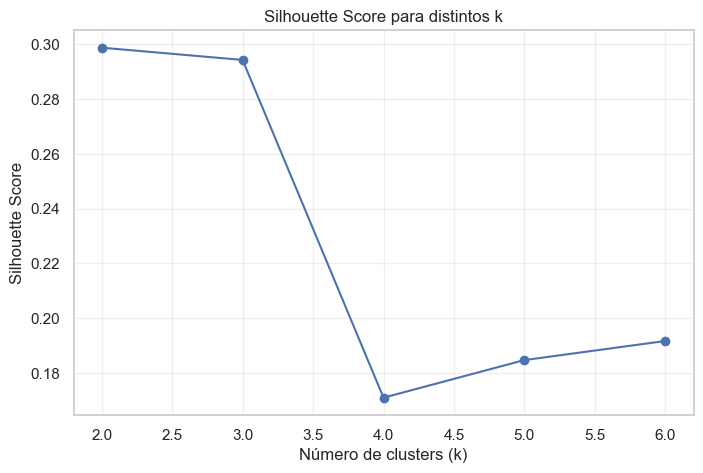

In [21]:
sil_scores = {}
for k in [2,3,4,5,6]:
    kmeans_tmp = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_tmp = kmeans_tmp.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels_tmp)
    sil_scores[k] = sil
    print(f"k={k}, Silhouette={sil:.4f}")

plt.figure(figsize=(8,5))
plt.plot(list(sil_scores.keys()), list(sil_scores.values()), marker='o')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score para distintos k')
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# Entrenamiento final con k=4   
k_opt = 3

kmeans = KMeans(n_clusters=k_opt, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_scaled)

df_cluster['cluster'] = labels
silhouette = silhouette_score(X_scaled, labels)

print(f"Clusters encontrados: {df_cluster['cluster'].nunique()}")
print(f"Silhouette Score global: {silhouette:.4f}")
df_cluster['cluster'].value_counts()

Clusters encontrados: 3
Silhouette Score global: 0.2943


cluster
1    18351
0     4387
2       64
Name: count, dtype: int64

In [23]:
# Estadísticas por cluster
cluster_stats = df_cluster.groupby('cluster').agg({
    'price': ['mean','median','min','max'],
    'accommodates': 'mean',
    'bedrooms': 'mean',
    'bathrooms': 'mean',
    'availability_365': 'mean',
    'minimum_nights': 'mean',
    'number_of_reviews': 'mean'
}).round(2)

cluster_stats

price                         accommodates bedrooms bathrooms  \
            mean  median    min      max         mean     mean      mean   
cluster                                                                    
0        2825.04  2321.0  169.0  10000.0         6.22     2.69      2.40   
1        1008.21   880.0  137.0   5851.0         2.60     1.20      1.18   
2        2152.02  1199.0  199.0  10000.0         3.94     2.00      1.90   

        availability_365 minimum_nights number_of_reviews  
                    mean           mean              mean  
cluster                                                    
0                 242.54           3.10             60.06  
1                 259.12           2.98             56.51  
2                 318.70         303.12             22.28

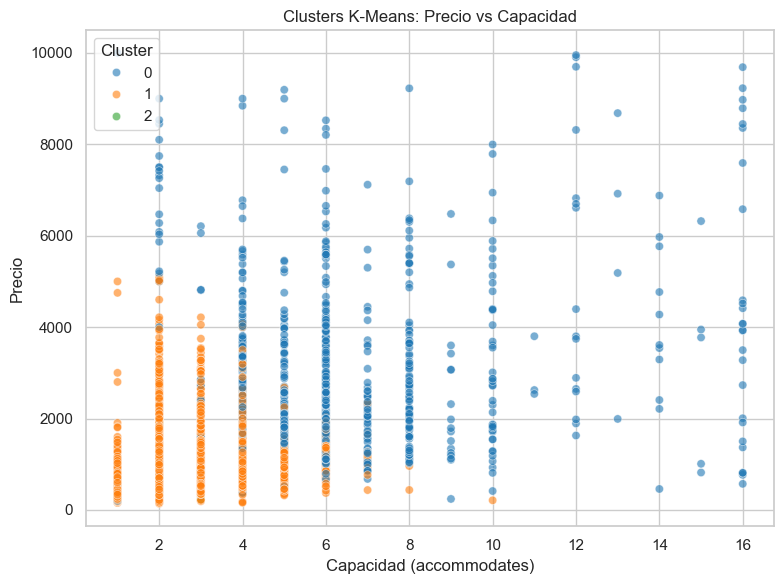

In [24]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_cluster.sample(min(5000, len(df_cluster))), 
    x='accommodates', y='price', 
    hue='cluster', palette='tab10', alpha=0.6
)
plt.title('Clusters K-Means: Precio vs Capacidad')
plt.xlabel('Capacidad (accommodates)')
plt.ylabel('Precio')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

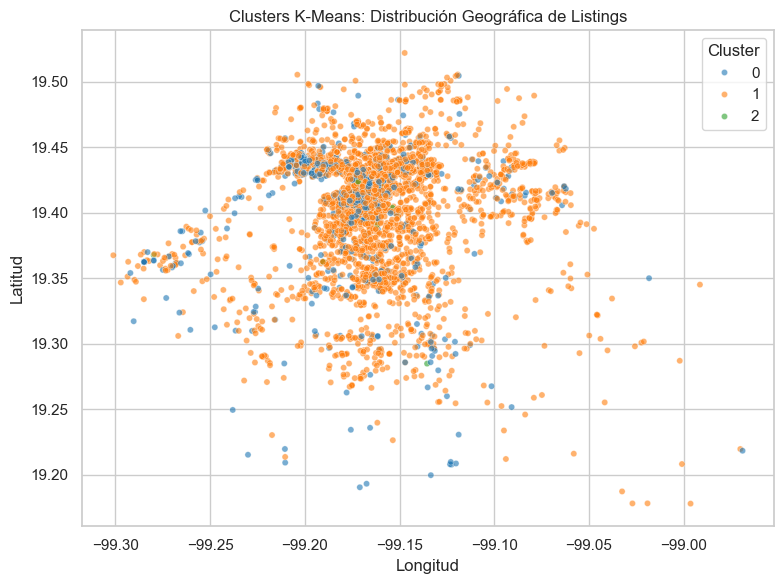

In [25]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_cluster.sample(min(5000, len(df_cluster))),
    x='longitude', y='latitude',
    hue='cluster', palette='tab10', alpha=0.6, s=20
)
plt.title('Clusters K-Means: Distribución Geográfica de Listings')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()